In [14]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [15]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
#sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [16]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_sixteenth = fs.xh.values
yh_sixteenth = fs.yh.values

h  = np.array(av['h'][:,:,:,:]);
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.transpose(np.tile(drho,[100,len(yh_sixteenth),len(xh_sixteenth),1]),(0,3,1,2)); 
drhodz=drhomat/h
N2=(9.81/1025.)*drhodz
#N2[N2>1.e-3] =np.nan 
mask=N2*0.0+1.0

print('done 0')
#Outputs are comprised of 20 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
print('done 1')
h[np.isnan(h)]=0.0
#Filtering out places where N2 is large
u  = u*mask; v  = v*mask; h = h*mask
Depth_4D=np.transpose(np.tile(np.nansum(h,axis=1),[Nlayers,1,1,1]),(1,0,2,3))
print('done 2')
#Compute thickness-weighted velocities at each layer
TW_u = u*h/Depth_4D; TW_v = v*h/Depth_4D;
#Computing barotropic velocities, as depth-mean, thickness-weighted velocities
BT_u = np.transpose(np.tile(np.nansum(TW_u,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
BT_v = np.transpose(np.tile(np.nansum(TW_v,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# #Baroclinic velocities as difference between raw and BT velocities:
#BC_u = u-BT_u; BC_v = v-BT_v;

#Total kinetic energy based on thickness-weighted velocity:
KE_tot = (0.5*(u)**2 + 0.5*(v)**2)*h/Depth_4D;
#Barotropic kinetic energy:
KE_BT_tot = (0.5*(BT_u)**2 + 0.5*(BT_v)**2)*h/Depth_4D; 

#METHOD 1 for baroclinic KE: 
KE_BC_tot_1 = (KE_tot-KE_BT_tot);

print(KE_tot.shape)
print('done')

done 0
done 1
done 2
(100, 15, 2240, 960)
done


In [17]:
#Summing quantities to be plotted in depth, then averaging in time (order doesn't matter)

Rd_dx_sixteenth= np.nanmean(np.array(av['Rd_dx'][:,:,:]),axis=0)
KE_tot_sixteenth=np.nanmean(np.nansum(KE_tot,axis=1),axis=0) 
KE_BT_tot_sixteenth=np.nanmean(np.nansum(KE_BT_tot,axis=1),axis=0) 

fraction_BT_sixteenth=KE_BT_tot_sixteenth/KE_tot_sixteenth
print(Rd_dx_sixteenth.shape)

(2240, 960)


In [18]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld setup
run=26 #1/8 degree NeverWorld setup
#run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
#sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [19]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_eighth = fs.xh.values
yh_eighth = fs.yh.values

h  = np.array(av['h'][:,:,:,:]);
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.transpose(np.tile(drho,[100,len(yh_eighth),len(xh_eighth),1]),(0,3,1,2)); 
drhodz=drhomat/h
N2=(9.81/1025.)*drhodz
#N2[N2>1.e-3] =np.nan 
mask=N2*0.0+1.0

print('done 0')
#Outputs are comprised of 20 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
print('done 1')
h[np.isnan(h)]=0.0
#Filtering out places where N2 is large
u  = u*mask; v  = v*mask; h = h*mask
Depth_4D=np.transpose(np.tile(np.nansum(h,axis=1),[Nlayers,1,1,1]),(1,0,2,3))
print('done 2')
#Compute thickness-weighted velocities at each layer
TW_u = u*h/Depth_4D; TW_v = v*h/Depth_4D;
#Computing barotropic velocities, as depth-mean, thickness-weighted velocities
BT_u = np.transpose(np.tile(np.nansum(TW_u,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
BT_v = np.transpose(np.tile(np.nansum(TW_v,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# #Baroclinic velocities as difference between raw and BT velocities:
#BC_u = u-BT_u; BC_v = v-BT_v;

#Total kinetic energy based on thickness-weighted velocity:
KE_tot = (0.5*(u)**2 + 0.5*(v)**2)*h/Depth_4D;
#Barotropic kinetic energy:
KE_BT_tot = (0.5*(BT_u)**2 + 0.5*(BT_v)**2)*h/Depth_4D; 

#METHOD 1 for baroclinic KE: 
KE_BC_tot_1 = (KE_tot-KE_BT_tot);

print(KE_tot.shape)
print('done')

done 0
done 1
done 2
(100, 15, 1120, 480)
done


In [20]:
#Summing quantities to be plotted in depth, then averaging in time (order doesn't matter)

Rd_dx_eighth= np.nanmean(np.array(av['Rd_dx'][:,:,:]),axis=0)
KE_tot_eighth=np.nanmean(np.nansum(KE_tot,axis=1),axis=0) 
KE_BT_tot_eighth=np.nanmean(np.nansum(KE_BT_tot,axis=1),axis=0) 

fraction_BT_eighth=KE_BT_tot_eighth/KE_tot_eighth
print(Rd_dx_eighth.shape)

(1120, 480)


In [21]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
#run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
#sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [22]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_quarter = fs.xh.values
yh_quarter = fs.yh.values

h  = np.array(av['h'][:,:,:,:]);
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.transpose(np.tile(drho,[100,len(yh_quarter),len(xh_quarter),1]),(0,3,1,2)); 
drhodz=drhomat/h
N2=(9.81/1025.)*drhodz
#N2[N2>1.e-3] =np.nan 
mask=N2*0.0+1.0

print('done 0')
#Outputs are comprised of 20 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
print('done 1')
h[np.isnan(h)]=0.0
#Filtering out places where N2 is large
u  = u*mask; v  = v*mask; h = h*mask
Depth_4D=np.transpose(np.tile(np.nansum(h,axis=1),[Nlayers,1,1,1]),(1,0,2,3))
print('done 2')
#Compute thickness-weighted velocities at each layer
TW_u = u*h/Depth_4D; TW_v = v*h/Depth_4D;
#Computing barotropic velocities, as depth-mean, thickness-weighted velocities
BT_u = np.transpose(np.tile(np.nansum(TW_u,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
BT_v = np.transpose(np.tile(np.nansum(TW_v,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# #Baroclinic velocities as difference between raw and BT velocities:
#BC_u = u-BT_u; BC_v = v-BT_v;

#Total kinetic energy based on thickness-weighted velocity:
KE_tot = (0.5*(u)**2 + 0.5*(v)**2)*h/Depth_4D;
#Barotropic kinetic energy:
KE_BT_tot = (0.5*(BT_u)**2 + 0.5*(BT_v)**2)*h/Depth_4D; 

#METHOD 1 for baroclinic KE: 
KE_BC_tot_1 = (KE_tot-KE_BT_tot);

print(KE_tot.shape)
print('done')

done 0
done 1
done 2
(100, 15, 560, 240)
done


In [23]:
#Summing quantities to be plotted in depth, then averaging in time (order doesn't matter)

Rd_dx_quarter= np.nanmean(np.array(av['Rd_dx'][:,:,:]),axis=0)
KE_tot_quarter=np.nanmean(np.nansum(KE_tot,axis=1),axis=0) 
KE_BT_tot_quarter=np.nanmean(np.nansum(KE_BT_tot,axis=1),axis=0)

fraction_BT_quarter=KE_BT_tot_quarter/KE_tot_quarter
print(Rd_dx_quarter.shape)


(560, 240)


In [ ]:
#Variables of interest are Rd_dx_quarter, fraction_BT_quarter, fraction_BC_quarter
                        #  Rd_dx_eighth,  fraction_BT_eighth,  fraction_BC_eighth


In [45]:
#INTERPOLATING ONTO COARSE GRID

from scipy.interpolate import interp2d

x_coarse = np.linspace(0,60,241)
y_coarse = np.linspace(-70,70,561)

Rd_dx_sixteenth[np.isnan(Rd_dx_sixteenth)]=0.0
Rd_dx_eighth[np.isnan(Rd_dx_eighth)]=0.0
Rd_dx_quarter[np.isnan(Rd_dx_quarter)]=0.0


f1 = interp2d(xh_eighth, yh_eighth, Rd_dx_eighth); 
Rd_dx_eighth_interp = f1(x_coarse, y_coarse);
f11 = interp2d(xh_quarter, yh_quarter, Rd_dx_quarter); 
Rd_dx_quarter_interp = f11(x_coarse, y_coarse);
f111 = interp2d(xh_sixteenth, yh_sixteenth, Rd_dx_sixteenth); 
Rd_dx_sixteenth_interp = f111(x_coarse, y_coarse);

fraction_BT_sixteenth[np.isnan(fraction_BT_sixteenth)]=0.0
fraction_BT_eighth[np.isnan(fraction_BT_eighth)]=0.0
fraction_BT_quarter[np.isnan(fraction_BT_quarter)]=0.0

f2 = interp2d(xh_eighth, yh_eighth, fraction_BT_eighth); 
fraction_BT_eighth_interp = f2(x_coarse, y_coarse);
f22 = interp2d(xh_quarter, yh_quarter, fraction_BT_quarter); 
fraction_BT_quarter_interp = f22(x_coarse, y_coarse);
f222 = interp2d(xh_sixteenth, yh_sixteenth, fraction_BT_sixteenth); 
fraction_BT_sixteenth_interp = f222(x_coarse, y_coarse);


print(Rd_dx_eighth.shape)
print(Rd_dx_eighth_interp.shape)

(1120, 480)
(561, 241)


In [ ]:
#AVERAGING ONTO COARSE GRID to get 2x2 degree boxes. 
#originally 1/4 deg. sim is 560x240... we're degrading to a 70 x 30 box. Also do that with lon/lat for plotting


In [63]:
fraction_BT_sixteenth_interp.shape

(561, 241)

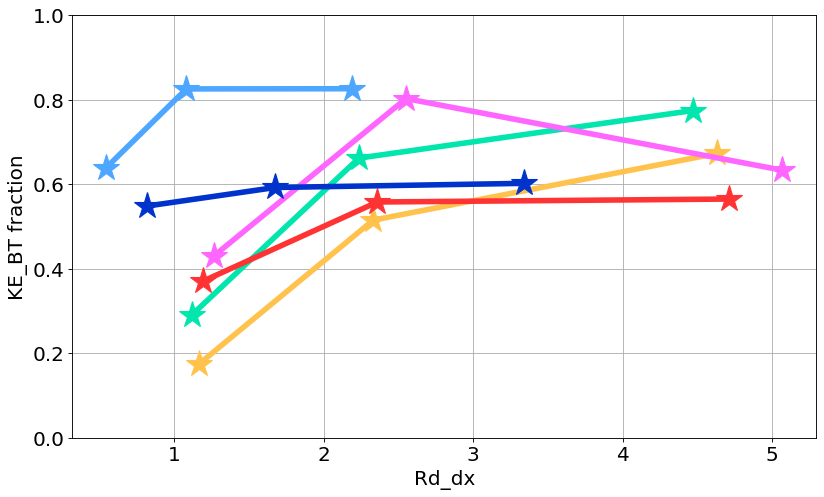

In [87]:
mask = np.nan*np.zeros([561,241]); #[200:360]=np.nan is -20 to +20
mask1=np.nan*np.zeros([561,241]); mask2=np.nan*np.zeros([561,241]); mask3=np.nan*np.zeros([561,241]); 
mask4=np.nan*np.zeros([561,241]); mask5=np.nan*np.zeros([561,241]); mask6=np.nan*np.zeros([561,241])
mask1[476:484,56:64]=1.;
mask2[476:484,176:184]=1.;
mask3[156:164,116:124]= 1.;
mask4[76:84,116:124]  = 1.;
mask5[396:404,116:124]=1.
mask6[76:84,176:184]  =1.
fig = plt.figure(figsize=(12, 7), dpi= 80, facecolor='w', edgecolor='k')


fraction_BT_sixteenth_interp[fraction_BT_sixteenth_interp==0]=np.nan
sixteenth_final1=np.nanmean(fraction_BT_sixteenth_interp*mask1);
Ratio_sixteenth1=np.nanmean(Rd_dx_sixteenth_interp[:,:]*mask1)
sixteenth_final2=np.nanmean(fraction_BT_sixteenth_interp*mask2);
Ratio_sixteenth2=np.nanmean(Rd_dx_sixteenth_interp[:,:]*mask2)
sixteenth_final3=np.nanmean(fraction_BT_sixteenth_interp*mask3);
Ratio_sixteenth3=np.nanmean(Rd_dx_sixteenth_interp[:,:]*mask3)
sixteenth_final4=np.nanmean(fraction_BT_sixteenth_interp*mask4);
Ratio_sixteenth4=np.nanmean(Rd_dx_sixteenth_interp[:,:]*mask4)
sixteenth_final5=np.nanmean(fraction_BT_sixteenth_interp*mask5);
Ratio_sixteenth5=np.nanmean(Rd_dx_sixteenth_interp[:,:]*mask5)
sixteenth_final6=np.nanmean(fraction_BT_sixteenth_interp*mask6);
Ratio_sixteenth6=np.nanmean(Rd_dx_sixteenth_interp[:,:]*mask6)

fraction_BT_eighth_interp[fraction_BT_eighth_interp==0]=np.nan
eighth_final1=np.nanmean(fraction_BT_eighth_interp*mask1);
Ratio_eighth1=np.nanmean(Rd_dx_eighth_interp[:,:]*mask1);
eighth_final2=np.nanmean(fraction_BT_eighth_interp*mask2);
Ratio_eighth2=np.nanmean(Rd_dx_eighth_interp[:,:]*mask2);
eighth_final3=np.nanmean(fraction_BT_eighth_interp*mask3);
Ratio_eighth3=np.nanmean(Rd_dx_eighth_interp[:,:]*mask3);
eighth_final4=np.nanmean(fraction_BT_eighth_interp*mask4);
Ratio_eighth4=np.nanmean(Rd_dx_eighth_interp[:,:]*mask4);
eighth_final5=np.nanmean(fraction_BT_eighth_interp*mask5);
Ratio_eighth5=np.nanmean(Rd_dx_eighth_interp[:,:]*mask5);
eighth_final6=np.nanmean(fraction_BT_eighth_interp*mask6);
Ratio_eighth6=np.nanmean(Rd_dx_eighth_interp[:,:]*mask6);

fraction_BT_quarter_interp[fraction_BT_quarter_interp==0]=np.nan
quarter_final1=np.nanmean(fraction_BT_quarter_interp*mask1);
Ratio_quarter1=np.nanmean(Rd_dx_quarter_interp[:,:]*mask1)
quarter_final2=np.nanmean(fraction_BT_quarter_interp*mask2);
Ratio_quarter2=np.nanmean(Rd_dx_quarter_interp[:,:]*mask2)
quarter_final3=np.nanmean(fraction_BT_quarter_interp*mask3);
Ratio_quarter3=np.nanmean(Rd_dx_quarter_interp[:,:]*mask3)
quarter_final4=np.nanmean(fraction_BT_quarter_interp*mask4);
Ratio_quarter4=np.nanmean(Rd_dx_quarter_interp[:,:]*mask4)
quarter_final5=np.nanmean(fraction_BT_quarter_interp*mask5);
Ratio_quarter5=np.nanmean(Rd_dx_quarter_interp[:,:]*mask5)
quarter_final6=np.nanmean(fraction_BT_quarter_interp*mask6);
Ratio_quarter6=np.nanmean(Rd_dx_quarter_interp[:,:]*mask6)

h1=plt.plot([Ratio_quarter1,Ratio_eighth1,Ratio_sixteenth1],[quarter_final1,eighth_final1,sixteenth_final1],'-*',color='#00e6ac',markersize=25,linewidth=5)

h2=plt.plot([Ratio_quarter2,Ratio_eighth2,Ratio_sixteenth2],[quarter_final2,eighth_final2,sixteenth_final2],'-*',color='#ffc34d',markersize=25,linewidth=5)

h3=plt.plot([Ratio_quarter3,Ratio_eighth3,Ratio_sixteenth3],[quarter_final3,eighth_final3,sixteenth_final3],'-*',color='#ff3333',markersize=25,linewidth=5)

h4=plt.plot([Ratio_quarter4,Ratio_eighth4,Ratio_sixteenth4],[quarter_final4,eighth_final4,sixteenth_final4],'-*',color='#4da6ff',markersize=25,linewidth=5)

h5=plt.plot([Ratio_quarter5,Ratio_eighth5,Ratio_sixteenth5],[quarter_final5,eighth_final5,sixteenth_final5],'-*',color='#ff66ff',markersize=25,linewidth=5)

h6=plt.plot([Ratio_quarter6,Ratio_eighth6,Ratio_sixteenth6],[quarter_final6,eighth_final6,sixteenth_final6],'-*',color='#0033cc',markersize=25,linewidth=5)

plt.xlabel('Rd_dx',fontsize=18)
plt.ylabel('KE_BT fraction',fontsize=18)
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
#plt.plot([0,50],[0,0],'k')
plt.ylim([0,1])
#plt.xlim([0,5])

#plt.legend((h1[1],h2[1],h3[1]),('1/4 deg.','1/8 deg.','1/16 deg.'),prop={'size': 18})
plt.grid()

In [67]:
print(np.nanmean(fraction_BT_sixteenth_interp*mask1))


0.7091802565404016


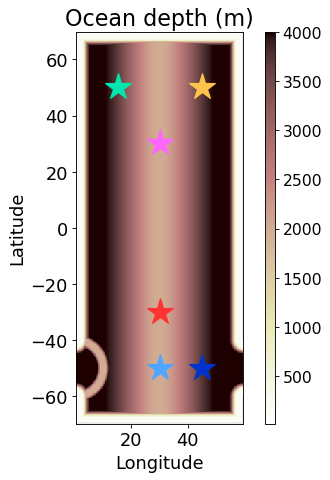

In [82]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh_quarter,yh_quarter,depth,cmap=cm.pink_r)
ax1.plot(xh_quarter[60],yh_quarter[480],'*',markersize=25,color='#00e6ac')
ax1.plot(xh_quarter[180],yh_quarter[480],'*',markersize=25,color='#ffc34d')
ax1.plot(xh_quarter[120],yh_quarter[160],'*',markersize=25,color='#ff3333')
ax1.plot(xh_quarter[120],yh_quarter[80],'*',markersize=25,color='#4da6ff')

ax1.plot(xh_quarter[120],yh_quarter[400],'*',markersize=25,color='#ff66ff')
ax1.plot(xh_quarter[180],yh_quarter[80],'*',markersize=25,color='#0033cc')
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

In [29]:
# mask = np.nan*np.zeros([141,61]); #[200:360]=np.nan is -20 to +20
# mask[60:81,:]=1.0

# fig = plt.figure(figsize=(12, 7), dpi= 80, facecolor='w', edgecolor='k')

# Ratio_sixteenth=Rd_dx_sixteenth_interp[:,:]
# Ratio_eighth=Rd_dx_eighth_interp[:,:]
# Ratio_quarter=Rd_dx_quarter_interp[:,:]
# fraction_BT_sixteenth_interp[fraction_BT_sixteenth_interp==0]=np.nan
# fraction_BT_eighth_interp[fraction_BT_eighth_interp==0]=np.nan
# fraction_BT_quarter_interp[fraction_BT_quarter_interp==0]=np.nan

# sixteenth_final=fraction_BT_sixteenth_interp*mask;
# eighth_final=fraction_BT_eighth_interp*mask;
# quarter_final=fraction_BT_quarter_interp*mask;
# #Either plot Ratio or Rd_dx, see which has better correlation.
# #Rd_dx[Rd_dx<10.]=np.nan
# h1=plt.plot((Ratio_quarter),(quarter_final),'*',color='#ffbb33')
# h2=plt.plot((Ratio_eighth),(eighth_final),'*',color='#ff0066')
# h3=plt.plot((Ratio_sixteenth),(sixteenth_final),'*',color='#6666ff')
# plt.xlabel('Rd_dx',fontsize=18)
# plt.ylabel('KE_BT fraction',fontsize=18)
# plt.plot([0,50],[0,0],'k')
# #plt.ylim([0,1])
# #plt.xlim([0,5])

# plt.legend((h1[1],h2[1],h3[1]),('1/4 deg.','1/8 deg.','1/16 deg.'),prop={'size': 18})
# plt.grid()